In [1]:
#https://github.com/bradkav/WIMpy_NREFT
from WIMpy import DMUtils as DMU

In [926]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
from scipy.integrate import quad
from scipy.integrate import simps
from scipy.integrate import cumtrapz
from scipy.optimize import minimize
from scipy.stats import rv_continuous
import time

# Ionization and Nuclear recoil Energy

The energy from a DM-nucleus interaction is the nuclear recoil energy. However, this energy is not directly measured in the DAMIC CCDs. This nuclear recoil of DM with the silicon of the CCDs pixels generates a certain number of pair electron-holes. The energy of this pairs is the ionization energy. The relation between this two energies is given a Lindhard Model in https://arxiv.org/pdf/1608.00957.pdf.

In [3]:
##To avoid RuntimeWarning
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

def lindhard(E):
    ep = E*10.5/np.power(14,7/3)
    g = 0.0100686*np.power(ep,-0.02907) + 0.0100686*np.power(ep,-0.02907) + ep
    fact = 2.81961*g/(1.+2.81961*g)
    return E*fact

The linhard model gives the ionization energy given a nuclear recoil. Sometimes is useful to obtain the nuclear recoil from the ionization energy. This is obtained from the inverse of the lindhard model.

In [260]:
from pynverse import inversefunc

def lindhard_inv(Ee):
    return inversefunc(lindhard, y_values = Ee).astype(float)

The derivative of the lindhard model will be useful for the chain rule of some derivatives. The inverse derivative it's just the inverse of the derivative value

In [13]:
from scipy.misc import derivative

def linhard_derivative(E):
    ### E in nuclear recoil
    return derivative(lindhard, E, dx=1e-6)

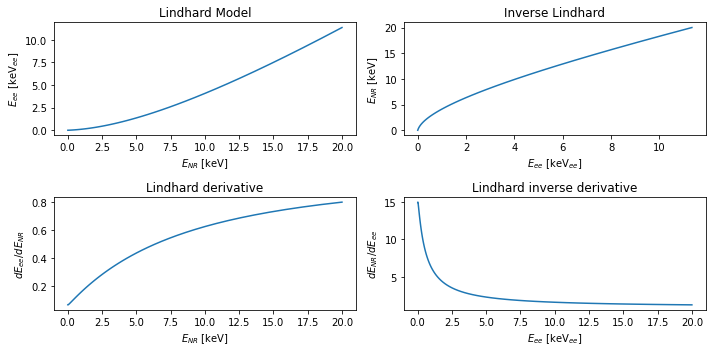

In [14]:
Enr = np.geomspace(1e-2, 20, 100) #nuclear recoil energies in keV

#Lindhard model
Eee = lindhard(Enr) #ionization energy in KeVee
fig, ax = plt.subplots(2,2)
ax[0,0].plot(Enr, Eee)
ax[0,0].set_xlabel(r"$E_{NR}$ [keV]")
ax[0,0].set_ylabel(r"$E_{ee}$ [keV$_{ee}$]")
ax[0,0].set_title("Lindhard Model")

#Linhard inverse
Enr_inv = lindhard_inv(Eee)
ax[0,1].plot(Eee,Enr_inv)
ax[0,1].set_ylabel(r"$E_{NR}$ [keV]")
ax[0,1].set_xlabel(r"$E_{ee}$ [keV$_{ee}$]")
ax[0,1].set_title("Inverse Lindhard")

#Linhard derivative
dEr_dEe = linhard_derivative(Enr)
ax[1,0].plot(Enr, dEr_dEe)
ax[1,0].set_ylabel(r"$dE_{ee}/dE_{NR}$ ")
ax[1,0].set_xlabel(r"$E_{NR}$ [keV]")
ax[1,0].set_title("Lindhard derivative")

#Linhard inverse derivative
dEe_dEr = 1/dEr_dEe
ax[1,1].plot(Enr, dEe_dEr)
ax[1,1].set_ylabel(r"$dE_{NR}/dE_{ee}$ ")
ax[1,1].set_xlabel(r"$E_{ee}$ [keV$_{ee}$]")
ax[1,1].set_title("Lindhard inverse derivative")

fig.tight_layout()
plt.show()

We want to know the expected event rate per kg of detector per day of signals. This rate will depend on the Energy of the nuclear recoils and is obtained from the Bradley's code.

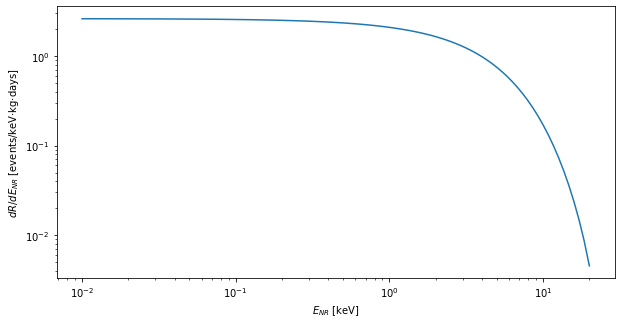

In [1171]:
#Properties of Silicon
N_p_Si, N_n_Si = 14, 14
#Properties of DM
mx, sigma = 10, 1e-40 #GeV, cm2
#Differential rate of events
dRdEr = DMU.dRdE_standard(Enr, N_p_Si, N_n_Si, mx, sigma)
plt.loglog(Enr, dRdEr)
plt.xlabel(r"$E_{NR}$ [keV]")
plt.ylabel(r"$dR/dE_{NR}$ [events/keV$\cdot$kg$\cdot$days]")
plt.show()

The measured quantity in a CCD is the ionization energy. We need to transform this rate from energy recoils to ionization energy. The experiment will also have a signal detection efficiency and an energy resolution which is gaussian. 

$$
    \frac{dR}{dE_{ee}} = \epsilon(E_{ee})\int_{E_{ee}^{min}}^{E_{ee}^{max}}\frac{dR(E_{NR},M,\sigma_{p})}{dE_{NR}} \cdot  \left|\frac{dE_{NR}}{dE_{ee}}\right|  \cdot G(E-E_{ee}|\sigma_{ee})\cdot dE
$$

But this is equivalent changing the variable of the integral from ionization energy to nuclear recoils.

$$
    \frac{dR}{dE_{ee}} = \epsilon(E_{ee})\int_{E_{NR}^{min}}^{E_{NR}^{max}}\frac{dR(E_{NR},M,\sigma_{p})}{dE_{NR}} \cdot G(E'-E_{NR}|\sigma_{NR})\cdot dE'
$$

We are using.
* Energy resolution $\sigma_{ee} = 4$ eV$_{ee}$.
* Efficiency is $\epsilon(E) = 0 $ if $x\leq4$ eV$_{ee}$ and $0.75$ if $x>4$ eV$_{ee}$

In [1169]:
def efficiency(E):
    if E <= 0.004:
        return 0   #Set efficiency to zero below 8 eV
    else:
        return 0.75
    
    
def resolution(E1, E2, sigma_E):
    ## E1 is the energy point of the gaussian.
    ## E2 is the center energy of the gaussian.
    #sigma_E = 4e-3 # 4 eV of resolution for DAMIC-M
    return (2*np.pi*sigma_E**2)**-0.5*np.exp(-0.5*(E1 - E2)**2/sigma_E**2)



def dR_dEe(Er, N_p_Si, N_n_Si, m_x, sigma_p):
    ### Energy recoil units are given
    sigma_Ee = 4e-3 # 4 eV of resolution for DAMIC-M
    sigma_Er = lindhard_inv(5*sigma_Ee)
    Ee = lindhard(Er)
    eff = efficiency(Ee)
    ## Integral limits in energy recoil units
    Emin, Emax = np.clip(Er-sigma_Er,0,100), np.clip(Er+sigma_Er,0,100)

    ### To implement the speed if eff = 0. We dont calculate the integral.
    if Ee>0.004:
        eff = 0.75
        ## Integral in units of energy recoil
        integrand = lambda x: DMU.dRdE_standard(x, N_p_Si, N_n_Si, m_x, sigma_p)*resolution(x,Er,sigma_Er)
        #print("drde: ",DMU.dRdE_standard(Er, N_p_Si, N_n_Si, m_x, sigma_p))
        dR = eff*quad(integrand,Emin,Emax,epsrel=1e-4)[0]
        #print("int: ", dR)
    else:
        dR = 0
    return dR


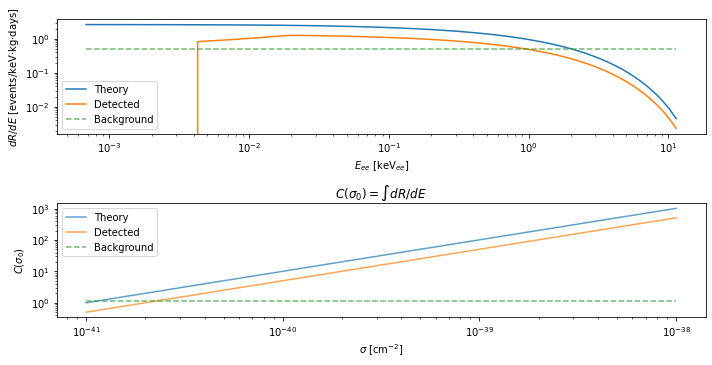

In [1172]:
dR_dE = np.array([dR_dEe(E, N_p_Si, N_n_Si, mx, sigma) for E in Enr])

fig, ax = plt.subplots(2,1)

ax[0].loglog(Eee, dRdEr, label = "Theory")
ax[0].loglog(Eee, dR_dE, label = "Detected")
ax[0].loglog(Eee, [0.5] * len(dR_dE), '--', alpha= 0.7, label = "Background")
ax[0].set_xlabel(r"$E_{ee}$ [keV$_{ee}$]")
ax[0].set_ylabel(r"$dR/dE$ [events/keV$\cdot$kg$\cdot$days]")
ax[0].legend(loc="best")


## Detected Constant
xsmin,xsmax, xsnum = -41, -38, 5
xs = np.linspace(xsmin,xsmax, xsnum)
cee = [quad(dR_dEe, Enr[0],Enr[-1], args=(N_p_Si, N_n_Si,mx,10 ** s),epsabs=1e-6)[0] for s in xs]
c = [quad(DMU.dRdE_standard, Enr[0],Enr[-1], args=(N_p_Si, N_n_Si,mx,10 ** s),epsabs=1e-6)[0] for s in xs]
cb = [quad(lambda x: 0.1, Eee[0],Eee[-1], epsabs=1e-6)[0] for s in xs]

ax[1].loglog(np.power(10,xs), c, alpha = 0.7, label = "Theory")
ax[1].loglog(np.power(10,xs), cee, alpha = 0.7, label = "Detected")
ax[1].loglog(np.power(10,xs), cb, '--', alpha = 0.7, label = "Background")
ax[1].set_xscale("log")
ax[1].set_ylabel(r"$C(\sigma_0)$")
ax[1].set_xlabel(r'$\sigma$ [cm$^{-2}$]')
ax[1].set_title("$C(\sigma_0)=\int dR/dE$")
ax[1].legend(loc="best")

fig.tight_layout()
plt.show()

This will be the detected signal spectrum on our CCD. Now we need to calculate the probabilty of obtaining a number of signals at a certain energy. This probability is the different rate per ionization energy divided by a constant that makes the integral over the range of energy equal to 1.

# Likelihood

We now need to calculate the likelihood. The energy in the fiducial region will be between 8eVee and 7keVee. The likelihood is given in https://arxiv.org/pdf/1607.07410.pdf.

$$
L(s,M|E) = e^{-s}\prod_{i}^{N} s\cdot f_s(E_i|M)
$$

Where $s= t_{expo}\cdot m_{det} \cdot \int_{fiducial}dR(\sigma_0)/dE_{ee}$ (expecter number of events for the given cross section). The $e^{-s}$ accounts the poissonian probability of having the given number of events with the expected number of events $Pois(N|s)$ as $\prod s= s^{N}$. And $f_s(E_i|M)$ is the PDF of the signal given by

$$
f_s(E|M) = \frac{1}{C(\sigma_0)}\frac{dR}{dE_{ee}}
$$

Where $dR/dE_{ee}$ is the detection differential rate and $C(\sigma_0)$ is the integral of the detection differential rate in the fiducial region.

We need to find the maximum likelihood but we have and algorithm to find the minimum of a function. We just need to calculate the negative likelihood. Also it's easier to compute the negative log-likelihood to do the calculation so

$$
-ln|L(s,M|E)| = s - \sum_i^N ln|s \cdot f_s(E_i|M)|
$$

In our case the number of events will be the length of the Energy array in the fiducial region. As we are going to use it as the events energy.

If we add a PDF for background the log-likelihood will be

$$
-ln|L(s,M|E)| = (s+b) - \sum_i^N ln|s \cdot f_s(E_i|M) + b \cdot f_b(E_i|M)|
$$

We will suppose a flat background distribution. The PDF in the fiducial region is given by

$$
f_b(E|M) = \epsilon_{Bkg}(E_{ee})\frac{1}{\Delta E}
$$

Where $b = N_{events}^{bkg}\cdot t_{expo}\cdot m_{det}$ and $R_{bkg}$ doesn't depend on energy. Where $\epsilon_{Bkg}(E_{ee}) = 1, E_{ee} > 8$ eV$_{ee}$ and $\epsilon_{Bkg}(E_{ee}) = 0, E_{ee} \leq 8$ eV$_{ee}$.


In [1062]:
def log_likelihood(sigma_p,Er,Ermin,Ermax, N_p_Si, N_n_Si, m_x, texp_mass,detection=False, background=False):
    #s_o = sigma_p
    sigma_p = np.power(10, sigma_p)
    if detection:
        dR = np.array([dR_dEe(E, N_p_Si, N_n_Si, m_x, sigma_p) for E in Er])
        C_sigma0 = quad(dR_dEe, Ermin,Ermax, args=(N_p_Si, N_n_Si,m_x,sigma_p),epsrel=1e-4)[0]
    else:
        dR = np.array([DMU.dRdE_standard(E, N_p_Si, N_n_Si, m_x, sigma_p) for E in Er])
        C_sigma0 = quad(DMU.dRdE_standard, Ermin,Ermax, args=(N_p_Si, N_n_Si,m_x,sigma_p),epsrel=1e-4)[0]
    ### PDF signal and expected signal events
    fs  = dR/C_sigma0
    ## Expected signal events
    s = C_sigma0*texp_mass
    if background:
        ### Adds background
        dEee = lindhard(Ermax)-lindhard(Ermin)
        ## Calculates the number of events above the efficiency threshold
        # En teoria deberian ser todos si esta bien simulado¿
        Er_eff = np.array(Er)[np.array(Er)>lindhard_inv(0.004*2)]
        fb = np.array([1/dEee] * len(Er_eff))
        ### log likelihood
        b = background*texp_mass 
        _lnL = (s+b) - np.sum( np.log(s*fs + b*fb) )
    else:
        ### log likelihood
        _lnL = s - np.sum(np.log(s*fs))
        
    return _lnL

### Calculate the likelihood for the different cases.

In [687]:
Efiducial = Enr[(Enr>lindhard_inv(0.004)) & (Enr<lindhard_inv(7))]

mx = 10 #GeV
sigma = 6.47e-40 # Cross section
time = 1
mass = 1
dru = quad(DMU.dRdE_standard, Efiducial[0],Efiducial[-1], args=(N_p_Si,N_n_Si,mx,sigma),epsabs=1e-6)[0]
print(dru)
nevts = dru*time*mass
print('Number of events: ',nevts)
print(log_likelihood(-45., Efiducial, Efiducial[0],Efiducial[-1],N_p_Si, N_n_Si, mx, background=0.5))
Esimul = np.arange(lindhard_inv(0.008),lindhard_inv(1), nevts)


###Minimize theoretical lnlog drdE
si = minimize(log_likelihood, -40, args = (Efiducial, Efiducial[0],Efiducial[-1],N_p_Si, N_n_Si, mx, False, False))
print("Result of the minimum theoretical fit")
print(si.x)
print("Cross section: ", np.power(10,si.x))

### Minimize detected drdE
si = minimize(log_likelihood, -40, args = (Efiducial, Efiducial[0],Efiducial[-1],N_p_Si, N_n_Si, mx, True, False))
print("Result of the minimum detected fit")
print(si.x)
print("Cross section: ", np.power(10,si.x))

### Minimize detected drdE added background
si = minimize(log_likelihood, -40, args = (Efiducial, Efiducial[0],Efiducial[-1],N_p_Si, N_n_Si, mx, True, True))
print("Result of the minimum detected + background fit")
print(si.x)
print("Cross section: ", np.power(10,si.x))

63.83504054971177
Number of events:  63.83504054971177
234.79109738987674
Result of the minimum theoretical fit
[-39.14289651]
Cross section:  [7.19620445e-40]
Result of the minimum detected fit
[-38.84851085]
Cross section:  [1.4173893e-39]
Result of the minimum detected + background fit
[-38.85508246]
Cross section:  [1.39610326e-39]


### Some plots to cross check the distributions

0.3128415638086045
0.312841556763659
0.3128415453794541
0.31284154556305266
0.31284154556305266


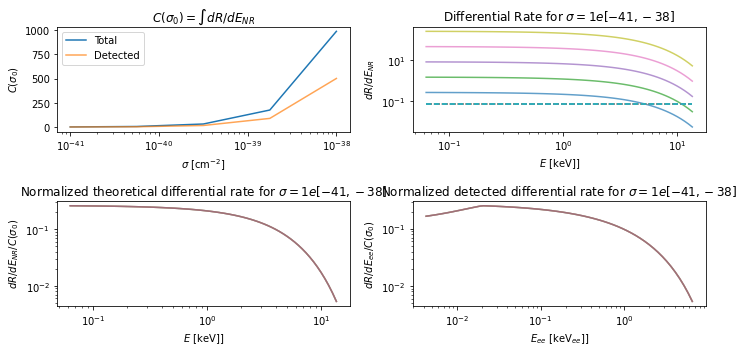

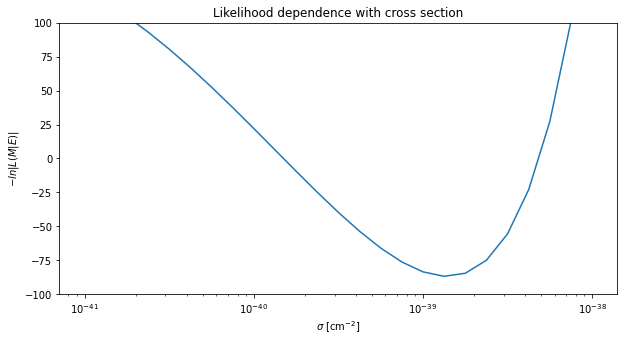

In [212]:
### Plot the parameters of the likelihood
xsmin,xsmax, xsnum = -41, -38, 5
xs = np.linspace(xsmin,xsmax, xsnum)
## Integration Constant
c = [quad(DMU.dRdE_standard, Efiducial[0],Efiducial[-1], args=(N_p_Si, N_n_Si,mx,10 ** s),epsabs=1e-6)[0] for s in xs]
## Detected Constant
cee = [ quad(dR_dEe, Efiducial[0],Efiducial[-1], args=(N_p_Si, N_n_Si,mx,10 ** s),epsabs=1e-6)[0] for s in xs]
#cee = xs

fig1, ax1 = plt.subplots(2,2)

ax1[0,0].plot(np.power(10,xs), c,label="Total")
ax1[0,0].plot(np.power(10,xs), cee, alpha = 0.7,label = "Detected")
ax1[0,0].set_xscale("log")
ax1[0,0].set_ylabel(r"$C(\sigma_0)$")
ax1[0,0].set_xlabel(r'$\sigma$ [cm$^{-2}$]')
ax1[0,0].set_title("$C(\sigma_0)=\int dR/dE_{NR}$")
ax1[0,0].legend(loc="best")

for sj in xs:
    sj = np.power(10,sj)
    c = quad(DMU.dRdE_standard, Efiducial[0],Efiducial[-1], args=(N_p_Si, N_n_Si,mx,sj),epsabs=1e-6)[0]
    ax1[0,1].loglog(Efiducial, DMU.dRdE_standard(Efiducial, N_p_Si, N_n_Si, mx, sj), alpha = 0.7)
    ax1[0,1].loglog(Efiducial, [1/(Efiducial[-1]-Efiducial[0])] * len(Efiducial), '--')
ax1[0,1].set_ylabel(r'$dR/dE_{NR}$')
ax1[0,1].set_xlabel(r'$E$ [keV]]')
ax1[0,1].set_title(r"Differential Rate for $\sigma=1e[{},{}]$".format(xsmin,xsmax))   
    

for i,sj in enumerate(xs):
    s_o = np.round(sj,1)
    sj = np.power(10,sj)
    c = quad(DMU.dRdE_standard, Efiducial[0],Efiducial[-1], args=(N_p_Si, N_n_Si,mx,sj),epsabs=1e-6)[0]
    #print(DMU.dRdE_standard(Efiducial, N_p_Si, N_n_Si, mx, s))
    #print(s)
    #print("Constant:", c)
    ax1[1,0].loglog(Efiducial, DMU.dRdE_standard(Efiducial, N_p_Si, N_n_Si, mx, sj)/c, alpha = 0.4,label=r"$\sigma=1e$"+str(s_o))
    
ax1[1,0].set_ylabel(r'$dR/dE_{NR}/C(\sigma_0)$')
ax1[1,0].set_xlabel(r'$E$ [keV]]')
ax1[1,0].set_title("Normalized theoretical differential rate for $\sigma=1e[{},{}]$".format(xsmin,xsmax))

for i,sj in enumerate(xs):
    s_o = np.round(sj,1)
    sj = np.power(10,sj)
    c = cee[i]
    #print(DMU.dRdE_standard(Efiducial, N_p_Si, N_n_Si, mx, s))
    #print(s)
    #print("Constant:", c)
    dR = np.array([dR_dEe(E, N_p_Si, N_n_Si, mx, sj) for E in Efiducial])
    ax1[1,1].loglog(lindhard(Efiducial), dR/c, alpha = 0.4,label=r"$\sigma=1e$"+str(s_o))
    
ax1[1,1].set_ylabel(r'$dR/dE_{ee}/C(\sigma_0)$')
ax1[1,1].set_xlabel(r'$E_{ee}$ [keV$_{ee}$]]')
ax1[1,1].set_title("Normalized detected differential rate for $\sigma=1e[{},{}]$".format(xsmin,xsmax))
fig1.tight_layout()
plt.show()

### Plot the lnLikelihood
xsmin,xsmax, xsnum = -41, -38, 25
xs = np.linspace(xsmin,xsmax, xsnum)
L = [log_likelihood(s, Efiducial, Efiducial[0],Efiducial[-1],N_p_Si, N_n_Si, mx, True, True) for s in xs]
plt.plot(np.power(10,xs), L)
plt.title("Likelihood dependence with cross section")
plt.xscale('log')
plt.ylabel(r'$-ln|L(M|E)$|')
plt.ylim([-100,100])
plt.xlabel(r'$\sigma$ [cm$^{-2}$]')

plt.show()

### Calculating the confidence value of the cross-section
https://emcee.readthedocs.io/en/stable/

[-39.1428965]


100%|██████████| 3000/3000 [21:41<00:00,  2.31it/s]


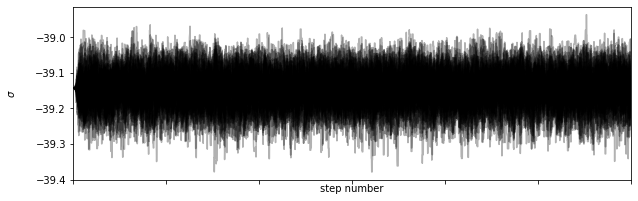

In [50]:
import emcee
np.random.seed(42)

def log_prior(sigma_p):
    if -100 < sigma_p < 0:
        return 0.0
    return -np.inf

def log_probability(sigma_p,Er, Ermin, Ermax,N_p_Si, N_n_Si, m_x):
    lp = log_prior(sigma_p)
    if not np.isfinite(lp):
        return -np.inf
    return lp - log_likelihood(sigma_p,Er, Ermin,Ermax,N_p_Si, N_n_Si, m_x)


sigma0 = minimize(log_likelihood, -33, args = (Efiducial, Efiducial[0],Efiducial[-1], N_p_Si, N_n_Si, mx)).x
print(sigma0)


pos = sigma0 + 1e-4 * np.random.randn(50,1)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=((Efiducial, N_p_Si, N_n_Si, mx)))
sampler.run_mcmc(pos, 3000, progress=True);


fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\sigma$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    

fig.delaxes(axes[-1])
axes[0].set_xlabel("step number");


#### 5th and 95th percentil calculation

In [56]:
import corner

tau = sampler.get_autocorr_time()
print(tau)

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

#fig = corner.corner(
#    flat_samples, labels=labels, truths=[m_true, b_true]
#);


inds = np.random.randint(len(flat_samples), size=100)

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], "\sigma")
    display(Math(txt))
    
    print("95th percentil: ", np.power(10,mcmc[1]+q[1]))
    print("Central vlue: ", np.power(10,mcmc[1]))
    print("5th percentile: ", np.power(10,mcmc[1]+q[0]))

[24.67830605]
(9650, 1)


<IPython.core.display.Math object>

95th percentil:  8.641460866306937e-40
Central vlue:  7.191143634544945e-40
5th percentile:  8.846727008916471e-40


# Simulate signal

We now need to simulate a signal in order to see if we obtain the number expected from the likelihood. The number of expected events will be 

$$
s = t_{expo}\cdot m_{detector} \cdot \int_{E_{ee}^{min}}^{E_{ee}^{max}} \frac{dR}{dE_{ee}} \cdot dE
$$

Number of theoretical events:  19.818246783988073
Number of expected events:  10.058271683205067
Number of detected events:  12


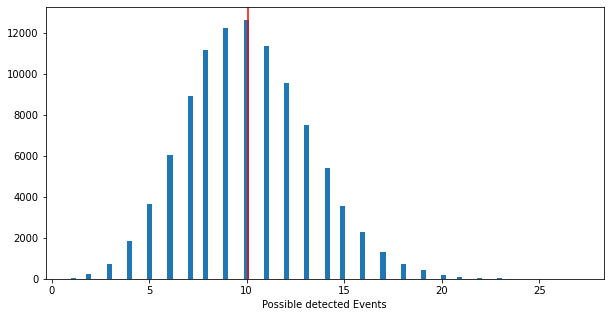

In [1137]:
np.random.seed(42)

mass_det = 1 #kg
expo_det = 2 #days
cross_section = 1e-40 #cm2
mass_dm = 10 #GeV
Eemin, Eemax = 4e-3, 7 #keV limits of fiducial region
Ermin, Ermax = float(lindhard_inv(Eemin) ), float(lindhard_inv(Eemax) )
C_sig = quad(dR_dEe, Ermin, Ermax, args=(N_p_Si, N_n_Si,mass_dm, cross_section),epsrel=1e-4)[0]

### Number of events is mass*expo*integral(dRdE)
s = mass_det*expo_det*C_sig
s_theo = mass_det*expo_det*quad(DMU.dRdE_standard, Ermin,Ermax, args=(N_p_Si, N_n_Si,mass_dm,cross_section),epsabs=1e-20)[0]

print("Number of theoretical events: ", s_theo)
print("Number of expected events: ", s)
n_det = np.random.poisson(s)
print("Number of detected events: ", n_det)

plt.hist(np.random.poisson(s,100000),bins=100, label="Poisson Dist")
plt.axvline(s, color = "r", label="Detected events")
plt.xlabel("Possible detected Events")
plt.show()

Integral Normalized dRdE:  1.0000013280374012


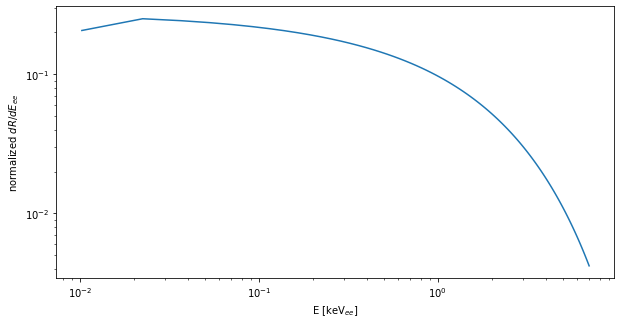

In [1138]:
def pdf_signal(Er, N_p_Si, N_n_Si, m_x, sigma_p, C_sigma0, detection=False):
    if detection:
        ### Input Er is in Ee units
        Er = lindhard_inv(Er)
        dR = dR_dEe(Er, N_p_Si, N_n_Si, m_x, sigma_p)
        #C_sigma0 = quad(dR_dEe, Emin, Emax, args=(N_p_Si, N_n_Si,m_x,sigma_p),epsabs=1e-6)[0]
    else:
        dR = DMU.dRdE_standard(Er, N_p_Si, N_n_Si, m_x, sigma_p)
        #C_sigma0 = quad(DMU.dRdE_standard, Emin, Emax, args=(N_p_Si, N_n_Si,m_x,sigma_p),epsabs=1e-6)[0]
    return dR/C_sigma0 #C_sigma0, dR/C_sigma0


### Normalized pdf signal
E_range = np.linspace(0,lindhard_inv(7),100)
dR_s = np.array([dR_dEe(E, N_p_Si, N_n_Si, mass_dm, cross_section) for E in E_range])
print("Integral Normalized dRdE: ", quad(dR_dEe, 0, lindhard_inv(7), args = (N_p_Si, N_n_Si, mass_dm, cross_section),epsabs=1e-6)[0]/C_sig)
plt.loglog(lindhard(E_range), dR_s/C_sig)
plt.xlabel(r"E [keV$_{ee}$]")
plt.ylabel(r"normalized $dR/dE_{ee}$")
plt.show()

## Inverse transform samplig to simulate the energy distribution of events.

https://en.wikipedia.org/wiki/Inverse_transform_sampling

We need a pdf in our case is $f_s(E|M)$. Now we need to calculate the cumulative distribution function wich is obtained by doing

$$
F_s(E|M) = \int_0^{E} f_s(E'|M) \cdot dE'
$$

Now we simulate a random number $u \in [0,1]$. The random energy of the event that will follow $f_s(E|M)$ is obtained from

$$
E_{event} = F_s^{-1}(u|M)
$$

--- 12.218995809555054 seconds ---


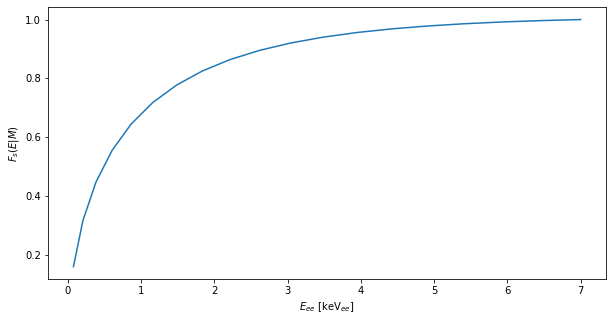

In [1139]:
def cdf_signal(Er, N_p_Si, N_n_Si, m_x, sigma_p, C_sigma0, detection=False):  
    """ Calculates the cumulative distribution function at value Er.
        It calculates it for the theoretical differential rate or the detected.
    """
    if detection:
        #Ee_max = lindhard(Er)
        #integral = quad(pdf_signal, 0, Ee_max, args = (N_p_Si, N_n_Si, m_x, sigma_p, C_sigma0, detection),epsabs=1e-20)[0]
        cdf = quad(dR_dEe, 0, Er, args = (N_p_Si, N_n_Si, m_x, sigma_p),epsrel=1e-4)[0]/C_sigma0

    else:
        cdf = quad(DMU.dRdE_standard, 0, Er, args = (N_p_Si, N_n_Si, m_x, sigma_p),epsrel=1e-4)[0]/C_sigma0
    return cdf


def random_signal(n_size, N_p_Si, N_n_Si, m_x, sigma_p, C_sigma0, detection=False):
    """ Simulates the energy of the events.
        Returns the energy in Nuclear recoil units.
    """

    u = np.random.rand(n_size)
    events = []
    for x in u:
        E_event = float(inversefunc(cdf_signal, y_values = x, args=(N_p_Si, N_n_Si, m_x, sigma_p, C_sigma0, detection)))
        if E_event < 0:
            """ This problem is due to dRdEe is not a continuos function.
                When it reaches the efficiency threshold it fails to calculate the inverse.
                We just recalculate the random number until we obtain E_event>0.
            """
            negative = True
            while negative:
                u_i = np.random.rand(1)
                E_event = float(inversefunc(cdf_signal, y_values = u_i, args=(N_p_Si, N_n_Si, m_x, sigma_p, C_sigma0, detection)))
                if E_event>0:
                    negative = False
        events.append(E_event)

    return events


#print(cdf_signal(11,  N_p_Si, N_n_Si, mass_dm, cross_section, s, True))
x_cdf = np.linspace(0,lindhard_inv(7),20)
start_time = time.time()
cdf = [cdf_signal(x,  N_p_Si, N_n_Si, mass_dm, cross_section, C_sig, True) for x in x_cdf]
print("--- %s seconds ---" % (time.time() - start_time))
plt.plot(lindhard(x_cdf), cdf)
plt.xlabel(r"$E_{ee}$ [keV$_{ee}$]")
plt.ylabel(r"$F_s(E|M)$")
plt.show()

    

In [1140]:
start_time = time.time()
signal_events = random_signal(n_det,  N_p_Si, N_n_Si, mass_dm, cross_section, C_sig, True)
print(signal_events)
print("--- %s seconds ---" % (time.time() - start_time))

[1.8413942126727052, 1.4715578142972028, 5.748621322229719, 0.839970723207454, 4.066599919277008, 4.918903731825449, 4.26989248005923, 0.6431897090748782, 1.724580686718994, 1.9109616967670122, 1.43182444371325, 4.3625039835295985]
--- 123.86285996437073 seconds ---


Finding the cross section
Cross Section exponent calculated:  [-39.92334212]
Cross section:  [1.19304791e-40]


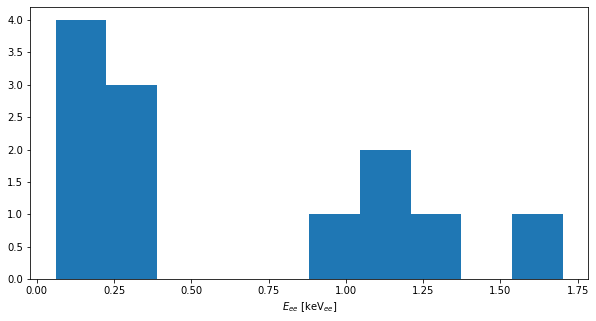

In [1141]:
plt.hist(lindhard(np.array(signal_events)), bins = 10)
plt.xlabel(r"$E_{ee}$ [keV$_{ee}$]")
print("Finding the cross section")
sigma0 = minimize(log_likelihood, -38, args = (signal_events, lindhard_inv(4e-3),lindhard_inv(7),N_p_Si, N_n_Si, mass_dm, mass_det*expo_det, True)).x
print("Cross Section exponent calculated: ", sigma0)
print("Cross section: ", np.power(10,sigma0))

In [1173]:
def random_background(n_size, Ermin, Ermax):
    """ For consistency we give Ermin and Ermax in Enr units.
    """
    E_bkg = []
    for i in range(n_size):
        E_i = np.random.uniform(Ermin, Ermax, 1)
        below_eff = True
        while E_i < lindhard_inv(0.004*2):
            E_i = np.random.uniform(Ermin, Ermax, 1)
        E_bkg.append(float(E_i))
    return E_bkg

### Expected backgoun 15+-3 events/kg days keV_ee
N = 0.1
C_b = N*(lindhard(E_range[-1])-lindhard(0.008)) #dRb/dE
b = mass_det*expo_det*C_b
n_b_det = np.random.poisson(b)
print("Number of background events: ", b)
print("Number of detected background events: ", n_b_det)
b_events = random_background(n_b_det, lindhard_inv(4e-3), lindhard_inv(7))
b_events

Number of background events:  1.3998904680514859
Number of detected background events:  1


[12.713539448536158]

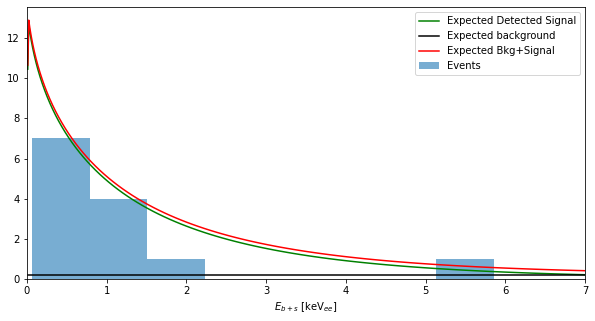

Finding the cross section
Cross Section exponent calculated:  [-39.58755003]
Cross section:  [2.58493707e-40]


In [1174]:
events = signal_events + b_events

bin_count = 8#int(np.ceil(np.log2(len(events))) + 1)
plt.hist(lindhard(np.array(events)), bins = bin_count, label = "Events",alpha = 0.6)#,histtype='step', linewidth=3,color = "k")
plt.xlabel(r"$E_{b+s}$ [keV$_{ee}$]")

### Plot of expected b+s over events
expected_s = dR_s*C_sig*mass_det*expo_det
plt.plot(lindhard(E_range), expected_s , label = "Expected Detected Signal", color = "g")
expected_b = np.array([N*mass_det*expo_det] * len(E_range))
plt.plot(lindhard(E_range), expected_b, label = "Expected background", color = "k")
plt.plot(lindhard(E_range), expected_s +expected_b, label = "Expected Bkg+Signal", color = "r" )
plt.legend(loc="best")
plt.xlim(0,7)
plt.show()


### Finding cross section b+s
print("Finding the cross section")
sigma0 = minimize(log_likelihood, -38, args = (events, lindhard_inv(4e-3),lindhard_inv(7),N_p_Si, N_n_Si, mass_dm, True, C_b)).x
print("Cross Section exponent calculated: ", sigma0)
print("Cross section: ", np.power(10,sigma0))

# Only Background Log-likelihood

The log-likelihood for background only is obtained from $-ln|L(M|E,s=0)|$

$$
-ln|L(M|E,s=0)| = b - N_{events}\cdot ln|b \cdot f_b(E_i|M)|
$$

We will suppose a flat background distribution. The rate of background events is constant

$$
\frac{dR_b}{dE_{ee}} = \frac{C_b}{\Delta E_{ee}}
$$

Where $C_b$ is 

$$
C_b = \int \frac{dR_b}{dE_{ee}}dE_{ee}
$$

But the quantity that we know ($N$) is the expected number of background events per $keV_{ee}\cdot days\cdot kg$. We can obtain $C_b$ by doing

$$
N = C_b/\Delta E_{ee} \rightarrow C_b= N\Delta E_{ee}
$$

The PDF in the fiducial region is given by

$$
f_b(E_{ee}|M) = \frac{1}{\Delta E_{ee}}
$$

Where $b = C_b\cdot t_{expo}\cdot m_{det}$ and $R_{bkg}$ doesn't depend on energy.

In [1175]:
def log_likelihood_bkg(b, Enr, Ermin,Ermax):
    """ Log Likelihood with s = 0 and all parameters free.
    """
    #b = C_b*t_exp_mass
    Enr = np.array(Enr)
    dEee = lindhard(Ermax)-lindhard(Ermin)
    fb_eff = len(Enr[Enr > lindhard_inv(0.004*2)])*np.log(b/dEee)
    _lnL = b - fb_eff
    return _lnL

b0 = minimize(log_likelihood_bkg, 1, args = (events, lindhard_inv(4e-3),lindhard_inv(7))).x
print("b0: ", b0)

lnL_b = -log_likelihood_bkg(b0, events,lindhard_inv(4e-3),lindhard_inv(7)) 
lnL_s = -log_likelihood(sigma0, events,lindhard_inv(4e-3),lindhard_inv(7),N_p_Si, N_n_Si, mass_dm, mass_det*expo_det,True, C_b)
print("Max Likelihood Background: ", lnL_b)
print("Max Likelihood Signal: ", lnL_s)

#c = np.linspace(30,60,1000)
#plt.plot(c, [log_likelihood_bkg(c_i, events,lindhard_inv(4e-3),lindhard_inv(7)) for c_i in c] )
#deltaLL = -np.log(np.exp(-lnL_b)/np.exp(-lnL_s))
#print("Delta ln-likelihood: ", deltaLL)

deltaLL = lnL_b-lnL_s
print("Delta ln-likelihood: ", deltaLL)
print("DM Discovered!!!!!") if deltaLL > 4.5 else print("95% sure I havent seen DM around:(")

b0:  [12.99991713]
Max Likelihood Background:  [-4.9450595]
Max Likelihood Signal:  -12.42349164154663
Delta ln-likelihood:  [7.47843214]
DM Discovered!!!!!


# Pruebas

In [ ]:
#x = np.linspace(0,101,100)
#y = x
 
#from scipy.interpolate import UnivariateSpline
#spl = UnivariateSpline(Eee, dR_dE , s=0)
#plt.loglog(Eee[lindhard(Eee)>1e-10],) 
#plt.show()

## EEMCE Confidence region

In [ ]:
### Example

np.random.seed(42)
x = np.linspace(0,100,100)
#yerr = np.array([0.1] * len(x))
yerr = np.random.normal(1,0.2,len(x))
m_true, b_true = 0.5,1
y = m_true*x + b_true + yerr

def log_l(theta,x,y,yerr):
    m,b = theta
    model = m*x+b
    #print((y-model)**2/y_err**2)
    sigma2 = yerr ** 2
    return np.sum((y-model) ** 2 /sigma2)



def log_prior(theta):
    m,b = theta
    if -2 < m < 3 and -1 < b < 5:
        return 0.0
    return -np.inf

def log_lp(theta,x,y,yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp - log_l(theta,x,y,yerr)

soln = minimize(log_l, [2,7], args=(x,y,yerr))
print(soln.x)
m,b = soln.x


plt.errorbar(x,y, yerr = yerr,fmt='.',label ="data")
plt.plot(x,m*x+b, label='fit')
plt.show()


pos = soln.x + 1e-4 * np.random.randn(32,2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_lp, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);


fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


In [ ]:
import corner

tau = sampler.get_autocorr_time()
print(tau)

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true]
);


inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x, np.dot(np.vander(x, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, m_true * x + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [ ]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x, np.dot(np.vander(x, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, m_true * x + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [ ]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 95])
    print(mcmc)
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

## Simulating random numbers with custom PDF
https://gist.github.com/amarvutha/c2a3ea9d42d238551c694480019a6ce1


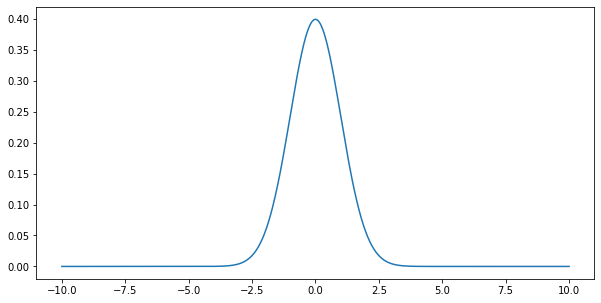

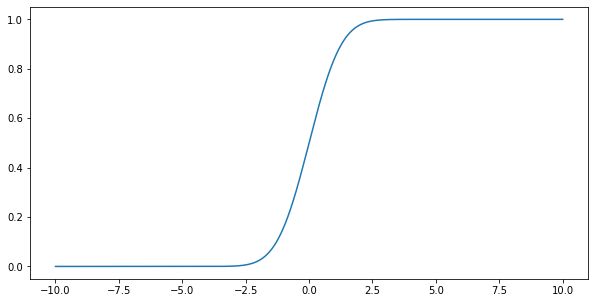

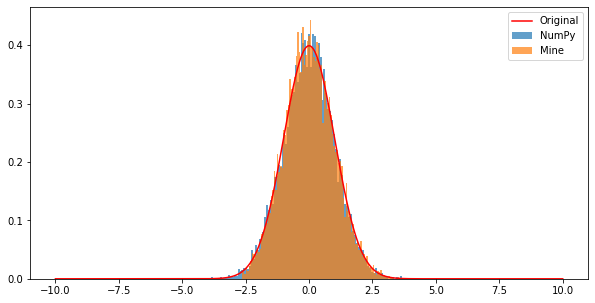

In [586]:
def gauss(x,mu0,sig):
    return np.exp(-(x-mu0)**2/(2*sig**2))/(np.sqrt(2*np.pi*sig))

def cdf_gauss(x, mu0, sig):
    return quad(gauss, -np.inf, x, args=(mu0,sig),epsabs=1e-6)[0]

x_gaus = np.linspace(-10,10,1000)
y_gaus = gauss(x_gaus, 0, 1)
plt.plot(x_gaus, y_gaus)
plt.show()


x_gaus_cdf = np.linspace(-10,10,1000)
y_gaus_cdf = [cdf_gauss(u,0,1) for u in x_gaus_cdf]
plt.plot(x_gaus_cdf,y_gaus_cdf)
plt.show()

def random_gauss(n_size,mu0,sig):
    u = np.random.uniform(low=4e-3, size=n_size)
    events = [float(inversefunc(cdf_gauss, y_values=x, args=(mu0,sig))) for x in u]
    return events

ev = random_gauss(10000,0,1)
plt.hist(np.random.normal(0,1,10000), bins=100,density = True, alpha = 0.7, label = "NumPy")
plt.hist(ev, bins=100, density = True, alpha = 0.7, label = "Mine")
plt.plot(x_gaus,y_gaus,color = "r", label = "Original")
plt.legend(loc="best")
plt.show()

In [927]:
class random_signal(rv_continuous):
    def _pdf(self, x, N_p_Si, N_n_Si, m_x, sigma_p, C_sigma0, detection):
        if detection:
            pdf = dR_dEe(x,N_p_Si, N_n_Si, m_x, sigma_p)/C_sigma0
        else:
            pdf = DMU.dRdE_standard(x, N_p_Si, N_n_Si, m_x, sigma_p)/C_sigma0
        return pdf
x = np.linspace(0.0, lindhard_inv(7), 100)

start_time = time.time()
signal_dist = random_signal(name="signal_dist", a=0.0, b=lindhard_inv(7))
#pdf_sig = signal_dist(N_p_Si=N_p_Si, N_n_Si=N_n_Si, m_x=mass_dm, sigma_p=cross_section, C_sigma0=C_sig, detection = True) 
samples = signal_dist.rvs(N_p_Si=N_p_Si, N_n_Si=N_n_Si, m_x=mass_dm, sigma_p=cross_section, C_sigma0=C_sig, detection = True, size=24)
print("--- %s seconds ---" % (time.time() - start_time))
plt.hist(samples, bins = 5)

KeyboardInterrupt: 

In [943]:
def cdf_mc_integral(n_size, Emin, Emax, N_p_Si, N_n_Si, m_x, sigma_p, C_sigma0, detection):
    E_rn = np.random.uniform(Emin, Emax, n_size)
    if detection:
        for E in E_rn:
            pdf_av = [dR_dEe(E, N_p_Si, N_n_Si, m_x, sigma_p)/C_sigma0 for E in E_rn]
    else:
        for E in E_rn:
            pdf_av = [DMU.dRdE_standard(x, N_p_Si, N_n_Si, m_x, sigma_p)/C_sigma0 for E in E_rn]
    return (Emax-Emin)*np.mean(pdf_av)

x = np.linspace(lindhard_inv(0.004), lindhard_inv(7),100)
cdf = [cdf_mc_integral(1000, lindhard_inv(0.004), E, N_p_Si, N_n_Si, mass_dm, cross_section, s, False)   for E in x]
plt.plot(x,cdf)

KeyboardInterrupt: 

## Python things

In [57]:
def hola(a,b,c=True, **kwargs):
    if c:
        return a+b
    else:
        if "Detection" in kwargs:
            print(kwargs["Detection"])
        else:
            print("Hola")
            
            
hola(1,2,True)

3

In [109]:
def adios(a,b,*args,c=False):
    if c:
        return a+b
    else:
        if "Detection" in args:
            print(args)
        else:
            print("Hola")
            
            
adios(1,2,["Detection"])

Hola
